In [64]:
#Check working directories
import os

In [65]:
os.getcwd()

'C:\\Users\\midhu\\Documents\\GitHub\\Restore-tensorflow-model'

In [66]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import time
from random import shuffle
from tqdm import tqdm as tqdm
#import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from alpha import create_traindata, random_mini_batch


%matplotlib inline

In [67]:
tf.__version__

'1.4.0'

In [68]:
TRAIN_DIR = ".\\train"
IMG_SIZE = 100
img_shape = (IMG_SIZE,IMG_SIZE,3)
num = 200

In [69]:
def create_traindata(num_data = 100, IMG_SIZE = 100, TRAIN_DIR = ".\\train"):
    training_data = []
    training_label = []
    for directory in os.listdir(TRAIN_DIR):
        path1 = os.path.join(TRAIN_DIR, directory)
        for i, img in tqdm(enumerate(os.listdir(path1))):
            if i < num_data:
                label = directory
                path2 = os.path.join(path1, img)
                img = cv2.imread(path2)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                training_label.append([np.array(label)])
                training_data.append([np.array(img)])
    print("{0} Files per each class loaded".format(num_data))
    return np.array(training_data), np.array(training_label)

In [70]:
data, label = create_traindata(num, IMG_SIZE, TRAIN_DIR)

200it [00:00, 386.46it/s]
200it [00:00, 406.25it/s]


200 Files per each class loaded


In [71]:
data = np.array(data).reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [72]:
#Shuffle
def shuffle_data(X, Y):
    m = X.shape[0]
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    return shuffled_X, shuffled_Y

In [73]:
data, label = shuffle_data(data, label)

In [74]:
label_df = pd.DataFrame(label, columns = ['classes'])
label_unique = label_df.classes.unique()

In [75]:
en = LabelEncoder()
en.fit(label_df.classes)
encoded_label = en.transform(label_df.classes)

In [76]:
label_df["encoded_label"] = encoded_label

In [77]:
x_val = data

In [78]:
label_val = np.array(label_df["classes"])
encoded_label_val = encoded_label #for confusion matrix in the end

In [79]:
x_val.shape

(400, 100, 100, 3)

In [80]:
def conv_layer(input, size_in, size_out, name="conv"):
    with tf.name_scope(name):
        w = tf.Variable(tf.truncated_normal([5, 5, size_in, size_out], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[size_out]), name="B")
        conv = tf.nn.conv2d(input, w, strides=[1, 1, 1, 1], padding="SAME")
        act = tf.nn.relu(conv + b)
        #act = tf.nn.dropout(act, keep_prob =0.7)
        tf.summary.histogram("weights", w)
        tf.summary.histogram("biases", b)
        tf.summary.histogram("activations", act)
        return tf.nn.max_pool(act, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

In [81]:
def predict(X_val):
    
    tf.reset_default_graph() 
    (m, n_H0, n_W0, n_C0) = X_val.shape             
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    
    
    
    conv1 = conv_layer(X,     3,  8,  "conv1")
    conv2 = conv_layer(conv1, 8,  16, "conv2")
    conv3 = conv_layer(conv2, 16, 32, "conv3")
    conv4 = conv_layer(conv3, 32, 64, "conv4")
    

    flattened = tf.contrib.layers.flatten(conv4)
    
    fc1 = tf.contrib.layers.fully_connected(flattened, 128, activation_fn = None)
    Z   = tf.contrib.layers.fully_connected(fc1,       2,   activation_fn = None)
  
    #summaryMerged = tf.summary.merge_all()
    
    #Saver object
    saver = tf.train.Saver()
    with tf.Session() as sess:
        k = saver.restore(sess, tf.train.latest_checkpoint('.\\saved_models'))
        #filename="./summary_log_1/run"+time.strftime("%Y%m%d-%H%M%S")
        #writer = tf.summary.FileWriter(filename, sess.graph) 
        
        #one step forwardprop
        #prob = sess.run((tf.nn.softmax(Z)), feed_dict={X:X_val})
        predict_op = tf.argmax(Z, 1) 
        pred = sess.run(predict_op, feed_dict={X: X_val})
        
    return pred #prob

In [82]:
pred= predict(x_val)

INFO:tensorflow:Restoring parameters from .\saved_models\16-02--1431


In [83]:
pred

array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0,

In [84]:
en = LabelEncoder()
en.fit(label_df.classes)
decoded_label = en.inverse_transform(pred)

In [85]:
pred,decoded_label

(array([1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,

In [86]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 25 
    
    #create fig with 5x5 sub-plots
    
    fig, axes = plt.subplots(5,5, figsize = (15,15))
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
        
        if cls_pred is None:
            xlabel = "True: {}".format(cls_true[i])
        else:
            xlabel = "True: {0}, \n Pred = {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel, fontsize = 12)
        
        #Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

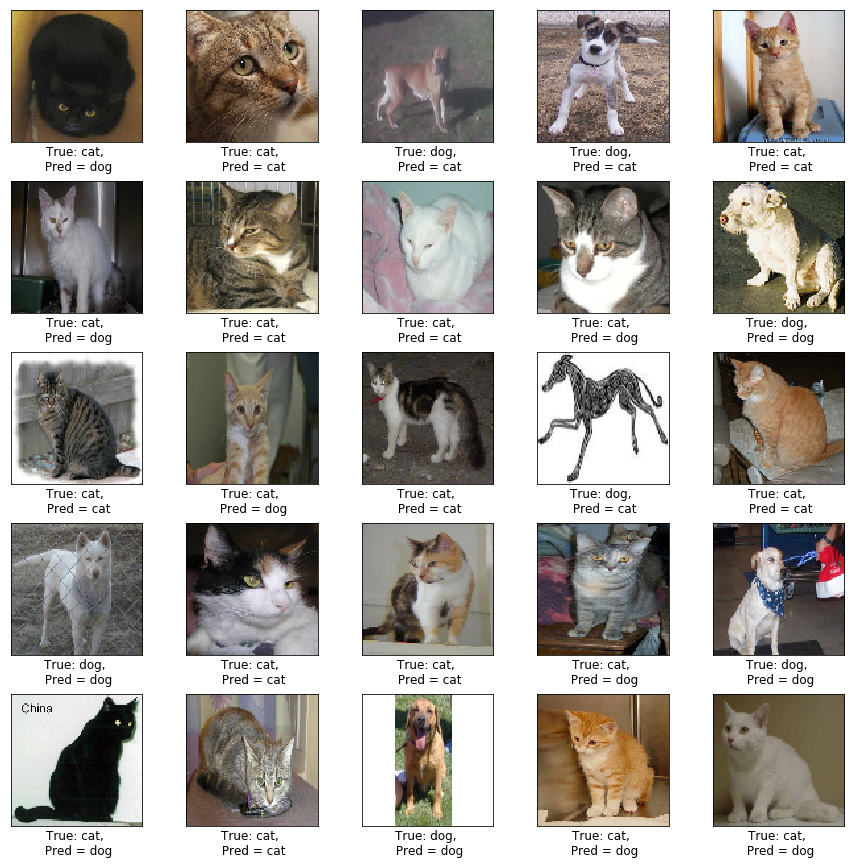

In [87]:
#get 25 images to plot
images = x_val[:25]
cls_true = label_val[:25]
cls_pred = decoded_label[:25]
plot_images(images, cls_true, cls_pred)

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [60]:
def plot_confusion_matrix(cls_true, cls_pred, labels):
    
     
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred, labels = labels)
    #print(cm)

    
    #plt.matshow(cm)
    #fig = plt.figure()
    ax = sns.heatmap(cm, annot=True, cmap='RdBu_r', linewidths=.5, linecolor='white')

    # Make various adjustments to the plot.
    plt.title('Confusion matrix of the classifier')

    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True', fontsize = 12)
    ax.figure.set_size_inches((10, 8))
    ax.tick_params(labelsize=12)
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')

    plt.show()

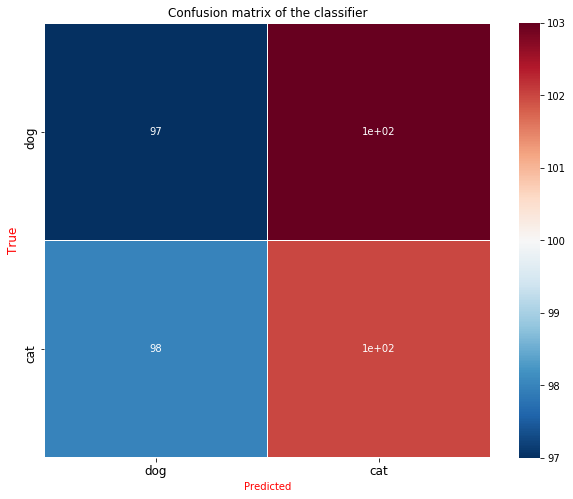

In [63]:
plot_confusion_matrix(label_val, decoded_label, label_unique)